<a href="https://colab.research.google.com/github/thearseno/pynotebooks/blob/main/Growth_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data-Driven Growth Strategy Analysis**
**Arsen Beglaryan**

13.Nov.23

# **Summary**
This analysis provides a detailed overview of user engagement and retention data of the photo editing app finding insights through queries and visualizations from provided 9 day period "app_opens" and "events" datasets. It encompasses analyses of daily user engagement across platforms, user behaviors on their first day, the initial user journey funnel, and the app user retention rate over a week. Executed through SQL queries and Python code within the scope of the notebook, these insights can be instrumental for strategies aimed at enhancing user engagement and overall growth.

After the initial library importing code below, a copy of a each task question is pasted followed by the answer details, the solution SQL query with corresponding result set after each.

In [84]:
#Importing all the necessary libraries and setting parameters
from google.colab import auth
from google.cloud import bigquery
from google.auth import default
auth.authenticate_user()
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import numpy as np

In [85]:
#Setting up auth parameters for connecting to Google BigQuery data wharehouse
credentials, project_id = default()
project_id='datatestproj-404419'
dataset_id='userbase'
client = bigquery.Client(project=project_id, credentials=credentials)

# **Part 1: SQL Question-1**
Write a SQL query to find the total number of daily average unique active users, daily
average sessions, and daily average new users per platform (android and apple) from the
"App Opens" dataset:

First, a CTE (Common Table Expression) is created to retrieve total unique occurrence counts per day and per platfrom for each metric.
Coalesce function is used to handle possible null values in 'is_first_app_open' boolean field (columns), in this case all possible occurances of null (empty) values will be treated as false. (In its current state our task dataset is clean, however, it is a good practice to keep coalesce in the prod code to handle nulls in future iterations).

In [86]:
#Assigining our SQL query to a variable "query_q1" for later reference and processing using Pyhon pandas library
query_q1 = f"""
with actives as
(select date(timestamp) as date, platform, count(distinct coalesce(device_skey,null)) as users, count(distinct session_skey) as sessions, count(case when coalesce(is_first_app_open, false) then 1 else null end) as newusers from `userbase.app_opens`
group by 1,2
order by 2)

--In the main outer query below, we finalize the code by retrieving the daily averages grouped by platform for each of the requested metrics. Our final query aggregates the average data from the precreated --CTE above.
select platform, round(avg(users)) as day_avg_actives, round(avg(sessions)) as day_avg_sessions, round(avg(newusers)) as day_avg_newusers
from actives
group by 1
order by 2 desc"""

Creating a variable dfq1(a Pandas dataframe) to load into and contain the results of our SQL Question-1 code when run in the cell above, then Outputting the query result, which is already loaded into our  variable dfq1(dataframe can be thought of as a table container).

We can clearly observe, that the daily average active user count, average session count and average new users count on Apple platform are visibly higher than ones on Android platform. It is worth noting that task datasets contain only 9 day period:

In [87]:
dfq1 = client.query(query_q1).to_dataframe()
dfq1.head()

,platform,day_avg_actives,day_avg_sessions,day_avg_newusers
0,apple,10044.0,10213.0,213.0
1,android,2972.0,3065.0,86.0


To make the comparison even more detailed a visualization is generated using the data fed from the dfq1 dataframe and matplotlib pyplot library Python code generating a simple bar chart:

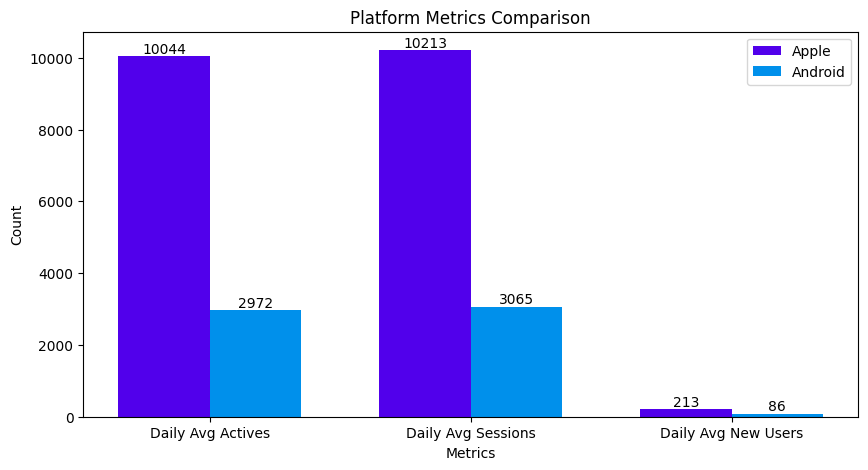

In [88]:
new_labels = {
    'day_avg_actives': 'Daily Avg Actives',
    'day_avg_sessions': 'Daily Avg Sessions',
    'day_avg_newusers': 'Daily Avg New Users'
}
dfq1.rename(columns=new_labels, inplace=True)
plt.figure(figsize=(10,5))
positions = np.arange(len(new_labels))
width = 0.35
apple_bars = plt.bar(positions - width/2, dfq1.iloc[0, 1:], width, label='Apple', color='#5100EB')
android_bars = plt.bar(positions + width/2, dfq1.iloc[1, 1:], width, label='Android', color='#0090EB')

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom')

add_labels(apple_bars)
add_labels(android_bars)
plt.xlabel('Metrics')
plt.ylabel('Count')
plt.title('Platform Metrics Comparison')
plt.xticks(positions, new_labels.values())
plt.legend()
plt.show()

# **Part 1: SQL Question-2**
From the "App Opens" dataset, write a SQL query to determine the number of new users
(first-time app opens) who have had more than one sessions on their first day per platform:

The SQL query is structured using CTEs. In the first CTE called 'sessionlist' we retrieve a list of all users (device_skey) who had more than 1 session along with dates, then in the second CTE called 'firstopens' we retrieve the dates of first app opens only. In our final CTE called 'firstdayesssions' we filter all those sessions from 'sessionlist' which are present in our 'firstopens' CTE containing dates of first app opens only.

In [89]:
#Assigining our SQL query to a variable "query_q2" for later reference and processing using Pyhon pandas library
query_q2 = f"""
with sessionlist as
(select platform, device_skey, date(timestamp) as date, count(distinct session_skey) as sessions from `userbase.app_opens`
group by 1,2,3
having sessions > 1),

firstopens as
(select platform, device_skey, date(timestamp) as firstdate from `userbase.app_opens`
where is_first_app_open),

firstdaysessions as

(select s.platform, s.device_skey, s.date, f.firstdate, s.sessions,
from sessionlist s inner join firstopens f on s.device_skey=f.device_skey and s.date = f.firstdate)

select platform, count(distinct device_skey) total_users
from firstdaysessions
group by 1"""

Creating a variable dfq2(a Pandas dataframe) to load into and contain the results of our SQL Question-2 code when run in the cell above, then Outputting the query result.

From the query result set we see that the number of new Apple platform users who had more than one session during their first app open day is only 12 and the value of Android new users is 8.

In [90]:
dfq2 = client.query(query_q2).to_dataframe()
dfq2

,platform,total_users
0,apple,12
1,android,8


# **Part 1: SQL Question-3**
Write a SQL query to derive the first session funnel per platform from the provided datasets,
using all available events. The first step of the funnel should be the user’s first app open.

Since the 'session_skey' is unique for every app open, it was used to perform full join of 'events' and 'app_opens' datasets
so we can count distinct occurances of cases where 'is_first_app_open' boolean field of our 2nd dataset 'app_opens' returns true along with events triggered, recorded in the 'events' dataset.

Coalesce function was used to handle possible missed or null values in the above mentioned booelan field, all null values will be treated as false.
Because our 'platfrom' field is used for groupping the results of count function while datasets are Full Joined (returning all results from both datasets and nulls where there's no match) coalesce is used to first count the platform values from events dataset, then where there was no event triggered during an app open it will count the platform
distinct occurances from the app_opens dataset portion of from the joined result.

In [91]:
#Assigining our SQL query to a variable "query_q3" for later reference and processing using Pyhon pandas library
query_q3 = f"""
SELECT
    coalesce (e.platform,a.platform) as platform,
    COUNT(DISTINCT CASE WHEN coalesce(a.is_first_app_open, false) THEN a.device_skey else null END) AS firsttime_open,
    COUNT(DISTINCT CASE WHEN e.event_name = 'registration_open' THEN e.device_skey ELSE NULL END) AS registration_open,
    COUNT(DISTINCT CASE WHEN e.event_name = 'registration_done' THEN e.device_skey ELSE NULL END) AS registration_done,
    COUNT(DISTINCT CASE WHEN e.event_name = 'subscription_offer_open' THEN e.device_skey ELSE NULL END) AS subscription_offer_open,
    COUNT(DISTINCT CASE WHEN e.event_name = 'subscription_done' THEN e.device_skey ELSE NULL END) AS subscription_done
FROM
  `userbase.events` e
FULL JOIN
  `userbase.app_opens` a ON e.session_skey = a.session_skey
GROUP BY 1
ORDER BY 3 DESC"""

First session funnel shows that only 5.7% of firsttime app openers eventualy purchased subscription on Apple platform and 3.6% on Android platform. A larger dataset with wider temporal range would be helpful here to determine the overal trends in comparison and understand the dynamics of growth.

In [92]:
dfq3 = client.query(query_q3).to_dataframe()
dfq3

,platform,firsttime_open,registration_open,registration_done,subscription_offer_open,subscription_done
0,apple,1914,1421,1217,1161,109
1,android,770,621,536,507,28


Using matplotlib pyplot and patches we can visualize funnel charts separately for each platform within the scope of the notebook. Available Tableau software would be instrumental in case there is a need to constantly monitor the dynamics.

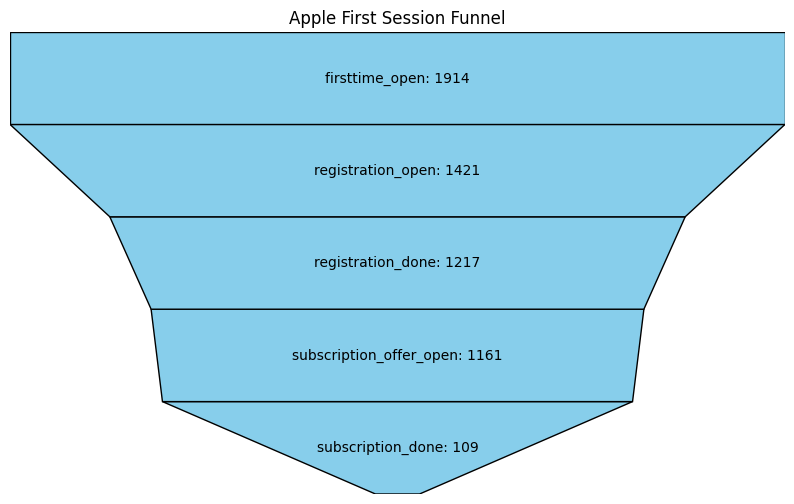

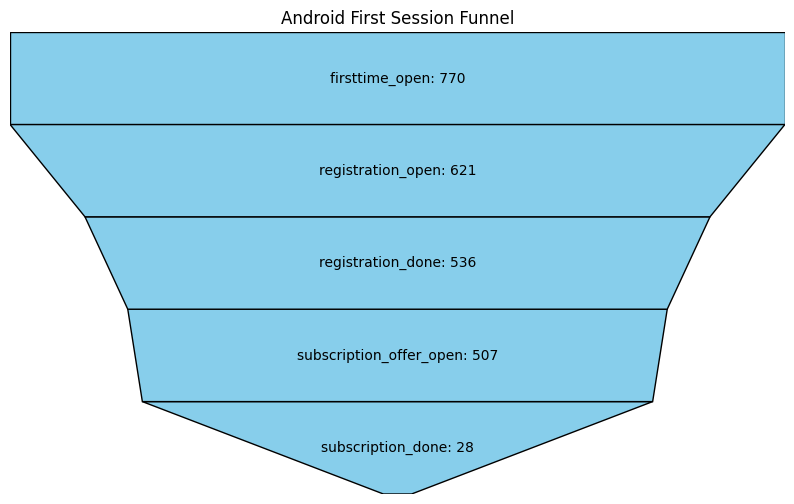

In [93]:
import matplotlib.patches as patches

def draw_symmetrical_funnel(data, title):
    stages = data.index[::-1]
    values = data.values[::-1]

    max_value = values.max()
    widths = (values / max_value) * 50

    fig, ax = plt.subplots(figsize=(10, 6))

    y = 0

    for i, width in enumerate(widths):
        lower_width = widths[min(i + 1, len(widths) - 1)]
        points = [(-width, y), (width, y), (lower_width, y + 1), (-lower_width, y + 1)]
        polygon = patches.Polygon(points, closed=True, facecolor='skyblue', edgecolor='black')
        ax.add_patch(polygon)

        ax.text(0, y + 0.5, f'{stages[i]}: {data[stages[i]]}', ha='center', va='center')

        y += 1

    ax.set_xlim(-50, 50)
    ax.set_ylim(0, len(stages))
    ax.set_title(title)
    ax.axis('off')

    plt.show()

apple_data = dfq3[dfq3['platform'] == 'apple'].drop('platform', axis=1).sum()
android_data = dfq3[dfq3['platform'] == 'android'].drop('platform', axis=1).sum()
draw_symmetrical_funnel(apple_data, 'Apple First Session Funnel')
draw_symmetrical_funnel(android_data, 'Android First Session Funnel')

# **Part 1: SQL Question-4**
Write a SQL query to calculate the user’s daily retention rate for a 7-day period:

(Hint: Daily retention rate is defined as the number of users who opened the app on a given
day and also on the previous day, divided by the number of users who opened the app on
the previous day.)

CTEs were created to return unique active users list (device_skey's) for each day of the 7 day period. Only registered users are counted.

Following device list CTEs we have CTEs of sets for each pair of days as per the task for daiy retention rate.
Left joins are used to identify users which appear on both days vs those which only appear during previous day of a pair.
The 'rrate' field represents Retention Rate percentage. The column values are calculated using safe_divide function to handle possible 'division by zero' errors and then rounded to 2 decimal places.

In [94]:
#Assigining our SQL query to a variable "query_q4" for later reference and processing using Pyhon pandas library
query_q4 = f"""
WITH devices_day0 AS (
    SELECT DISTINCT a.device_skey as d0
    FROM `userbase.app_opens` a
    WHERE DATE(a.timestamp) = '2023-10-05'AND a.user_skey <> 42),
devices_day1 AS (
    SELECT DISTINCT a.device_skey as d1
    FROM `userbase.app_opens` a
    WHERE DATE(a.timestamp) = '2023-10-06' AND a.user_skey <> 42),

devices_day2 AS (
    SELECT DISTINCT a.device_skey as d2
    FROM `userbase.app_opens` a
    WHERE DATE(a.timestamp) = '2023-10-07' AND a.user_skey <> 42),

devices_day3 AS (
    SELECT DISTINCT a.device_skey as d3
    FROM `userbase.app_opens` a
    WHERE DATE(a.timestamp) = '2023-10-08' AND a.user_skey <> 42),

devices_day4 AS (
    SELECT DISTINCT a.device_skey as d4
    FROM `userbase.app_opens` a
    WHERE DATE(a.timestamp) = '2023-10-09' AND a.user_skey <> 42),

devices_day5 AS (
    SELECT DISTINCT a.device_skey as d5
    FROM `userbase.app_opens` a
    WHERE DATE(a.timestamp) = '2023-10-10' AND a.user_skey <> 42),

devices_day6 AS (
    SELECT DISTINCT a.device_skey as d6
    FROM `userbase.app_opens` a
    WHERE DATE(a.timestamp) = '2023-10-11' AND a.user_skey <> 42),

devices_day7 AS (
    SELECT DISTINCT a.device_skey as d7
    FROM `userbase.app_opens` a
    WHERE DATE(a.timestamp) = '2023-10-12' AND a.user_skey <> 42),

Set1 as (
SELECT d0, d1 from
devices_day0 d_0
LEFT JOIN devices_day1 d_1 on d_0.d0 = d_1.d1),

Set2 as (
SELECT d1, d2 from
devices_day1 d_1
LEFT JOIN devices_day2 d_2 on d_1.d1 = d_2.d2),

Set3 as (
SELECT d2, d3 from
devices_day2 d_2
LEFT JOIN devices_day3 d_3 on d_2.d2 = d_3.d3),

Set4 as (
SELECT d3, d4 from
devices_day3 d_3
LEFT JOIN devices_day4 d_4 on d_3.d3 = d_4.d4),

Set5 as (
SELECT d4, d5 from
devices_day4 d_4
LEFT JOIN devices_day5 d_5 on d_4.d4 = d_5.d5),

Set6 as (
SELECT d5, d6 from
devices_day5 d_5
LEFT JOIN devices_day6 d_6 on d_5.d5 = d_6.d6),

Set7 as (
SELECT d6, d7 from
devices_day6 d_6
LEFT JOIN devices_day7 d_7 on d_6.d6 = d_7.d7),
Maindata as (
SELECT
'Day-1' as Day, ROUND(safe_divide(COUNT(d1), COUNT(d0)) * 100, 2) as rrate
FROM Set1
UNION ALL

SELECT
'Day-2' as Day, ROUND(safe_divide(COUNT(d2), COUNT(d1)) * 100, 2) as rrate
FROM Set2
UNION ALL

SELECT
'Day-3' as Day, ROUND(safe_divide(COUNT(d3), COUNT(d2)) * 100, 2) as rrate
FROM Set3
UNION ALL

SELECT
'Day-4' as Day, ROUND(safe_divide(COUNT(d4), COUNT(d3)) * 100, 2) as rrate
FROM Set4
UNION ALL

SELECT
'Day-5' as Day, ROUND(safe_divide(COUNT(d5), COUNT(d4)) * 100, 2) as rrate
FROM Set5
UNION ALL

SELECT
'Day-6' as Day, ROUND(safe_divide(COUNT(d6), COUNT(d5)) * 100, 2) as rrate
FROM Set6
UNION ALL

SELECT
'Day-7' as Day, ROUND(safe_divide(COUNT(d7), COUNT(d6)) * 100, 2) as rrate
FROM Set7)

SELECT * FROM Maindata
Order by 1"""

The average daily retention rate within the 7 day period is 2.08%. The dataset and the period being very small, the rate of retention being calculated per days can potentialy be confusing.

It is recomended to observe a larger dataset and look at retention rates per month or querter to see a clearer picture of dynamics and effects of a campain and/or a feature of study within a scope of A/B testing. Also would be a good practice to look at the same period of last year for example.

In [95]:
dfq4 = client.query(query_q4).to_dataframe()
dfq4

,Day,rrate
0,Day-1,2.33
1,Day-2,2.33
2,Day-3,2.26
3,Day-4,1.82
4,Day-5,1.95
5,Day-6,1.86
6,Day-7,2.06


# **Part 2: User Engagement Analysis**
The daily trend of user engagement is calculated through an SQL query retrieving unique device_skeys from the 'app_opens' dataset, later visualised using matplotlib pyplot python code.

In [96]:
#Assigining our SQL query to a variable "query_q5" for later reference and processing using Pyhon pandas library
query_q5 = f"""
select distinct date(timestamp) as date, count(distinct device_skey) as app_open
from `userbase.app_opens`
group by 1
order by 1"""

In [97]:
dfq5 = client.query(query_q5).to_dataframe()
dfq5

,date,app_open
0,2023-10-05,12279
1,2023-10-06,12605
2,2023-10-07,14003
3,2023-10-08,14812
4,2023-10-09,13551
5,2023-10-10,12545
6,2023-10-11,12233
7,2023-10-12,12431
8,2023-10-13,12687


Looking at the visalization below, we can see a jump in number of active users during 8th of October and minimum value during 11th of October.

Even though the datasets temporal range is very small, the clear increase in the number of active users can be furher analyzed in detail to understand possible contributing events and whether those were by chance or whether being positively and negatively correlated they can explain the increase of active users number.

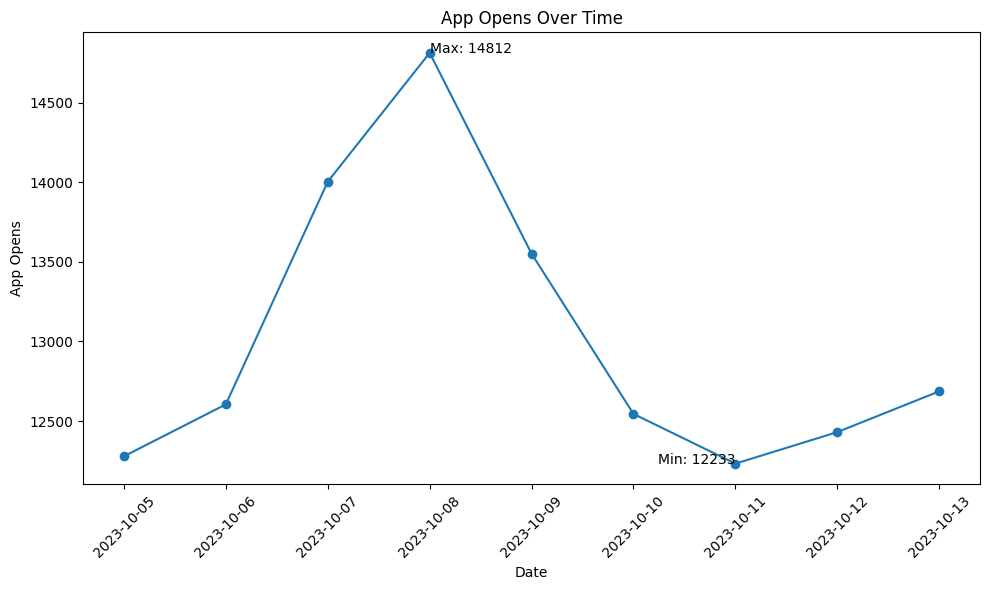

In [98]:
from matplotlib.dates import DateFormatter

dfq5['date'] = pd.to_datetime(dfq5['date'])

plt.figure(figsize=(10, 6))
plt.plot(dfq5['date'], dfq5['app_open'], marker='o')

plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))

min_value = dfq5['app_open'].min()
max_value = dfq5['app_open'].max()
min_date = dfq5[dfq5['app_open'] == min_value]['date'].iloc[0]
max_date = dfq5[dfq5['app_open'] == max_value]['date'].iloc[0]

plt.text(min_date, min_value, f'Min: {min_value}', horizontalalignment='right')
plt.text(max_date, max_value, f'Max: {max_value}', horizontalalignment='left')

plt.xlabel('Date')
plt.ylabel('App Opens')
plt.title('App Opens Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Through analyzing the main events dataset along with app_opens, it was found that a **total of 44,091** users(device_skey) did not trigger any event after opening the application.

Looking at the result set of the query below it is visible that close to 50% of users who opened the editor triggered a create flow event.
Among Apple users every 3 editor open event was followed by an object export. This number was 6 among Android users.

In [99]:
#Assigining our SQL query to a variable "query_q6" for later reference and processing using Pyhon pandas library
query_q6 = f"""
SELECT
    coalesce (e.platform,a.platform) as platform,
    COUNT(CASE WHEN e.event_name = 'editor_open' THEN e.device_skey ELSE NULL END) AS editor_open,
    COUNT(CASE WHEN e.event_name = 'create_flow_open' THEN e.device_skey ELSE NULL END) AS create_flow_open,
    COUNT(CASE WHEN e.event_name = 'object_export' THEN e.device_skey ELSE NULL END) AS object_export,
FROM
  `userbase.events` e
FULL JOIN
  `userbase.app_opens` a ON e.session_skey = a.session_skey
GROUP BY 1
ORDER BY 3 DESC"""

In [100]:
dfq6 = client.query(query_q6).to_dataframe()
dfq6

,platform,editor_open,create_flow_open,object_export
0,apple,139506,70085,400823
1,android,37391,18278,213383


Analyzing the percentage of users who open the editor, later engaged in registration finally completing the registration is done through an SQL query with CTEs for identifying the exact ids.

In [101]:
#Assigining our SQL query to a variable "query_q7" for later reference and processing using Pyhon pandas library
query_q7 = f"""
WITH editors AS (
  SELECT distinct device_skey as editor from `userbase.events`
  where event_name = 'editor_open'
),

registopen AS (
  SELECT distinct device_skey as regopen from `userbase.events`
  where event_name = 'registration_open'
),

registdone AS (
  SELECT distinct device_skey as regdone from `userbase.events`
  where event_name = 'registration_done'
),

combined AS (

  SELECT e.editor, ro.regopen, rd.regdone
  FROM editors e
  LEFT JOIN registopen ro ON e.editor = ro.regopen
  LEFT JOIN registdone rd ON e.editor = rd.regdone

)

SELECT count(editor) as editopen, count(regopen) as registopen, count(regdone) as registdone from combined"""

In [102]:
dfq7 = client.query(query_q7).to_dataframe()
dfq7

,editopen,registopen,registdone
0,61078,1227,1218


We can clearly see that within the portion of the dataset available to us only 2% of users who engage with the editor proceeds to open the registration and almost all of them complete the registration.

# **Growth Strategy Recommendations**

Before starting with the actual growth strategy recomendations it is worth paying attention at the scale and range of the available data. While it is clear the task and data are samples for testing only, it is still worth mentioning that a larger range of data is crucial for proper analysis. Appart from the data scale and diversity a certain time is needed for data science and analytics team to gain business and data understanding.

Looking at the [percentages](https://colab.research.google.com/drive/1X26FHDXMW4WZY1Y_bdM7VS6zTurTCwYN#scrollTo=Ly8IJ8OhzvYK&line=3&uniqifier=1) of users on both platforms, reching from first app open to actual subscription, it is worth investigating further within the available data and find out possible causes, compare trends with the data of the past.

It is recomended to conduct detailed analyses with approaches such as:

**A/B tests:**

On different features, UI changes or content. This helps in understanding what works best for different user segments.

**Retention Strategy Testing:**

Experiment with different retention strategies (like push notifications, emails, in-app messages and content recomendations) to see which reduces churn rate the most.

**RFM (Recency, Frequency, Monetary) Analysis:**

In case of having access to datasets containing financial KPI related data we should segment users based on how recently and frequently they use the app, and their spending behavior (if applicable). This helps in identifying most valuable users and those at risk of churning. The RFM can be looked at as more versatile tool than simply looking at finaicnal sums per user.

**Sentiment Analysis:**

Use Natural Language Processing (NLP) to analyze user reviews and feedback. This helps in understanding user sentiment towards the app and identifying areas for improvement.

**Pricing Strategy Analysis:**

If the app has paid features, test different pricing models or promotional offers to see which yields higher conversion rates.

**Mobility Matrix (if applicable)**
This type of analysis will clearly show the movement of users between pre set segments and potentially guide the marketing and promototinal activities to retain or reactivate users who, for example were in higher financial segments and sudenly stopped activities.

**Creating Interactive Live Dashboards**

In constant communication with internal stakeholders, analytics enginners etc., the data science team should work on creating interactive and live data connection enabled dashboards, for example using Tableau, and also conduct basic usage training for non-tech decision making stakeholders. This way the potential delays in data reporting using python, excel and other tools can be eliminated and crucial KPIs can be monitored live with decisions being made on time.

# **Final Overview**

Overall, leveraging the available code generated datasets and analytical approaches recomended above along with a real world large scale data, quick decisions can be made to develop an effective growth strategy for the photo editing app.

As it is the case with tools development, data analytics is also highly iterative and never stopping process, which as well depends on feedbacks and should be continuously modified and improved.